# Unified Classification Example with Random Forest and Model Report

An example of Unified Calssification with Random Forest using Diabetes Dataset. 



# Pima Indians Diabetes Dataset

Original data comes from National Institute of Diabetes and Digestive and Kidney Diseases. The collected dataset is aiming at, based on certain diagnostic measurements, diagnostically predicting whether or not a patient has diabetes. In particular, patients contained in the dataset are females of Pima Indian heritage, all above the age of 20. Dataset is form Kaggle, for tutorials use only.

The dataset contains the following diagnositic <b>attributes</b>:<br>
$\rhd$ "PREGNANCIES" - Number of times pregnant,<br>
$\rhd$ "GLUCOSE" - Plasma glucose concentration a 2 hours in an oral glucose tolerance test,<br>
$\rhd$ "BLOODPRESSURE" -  Diastolic blood pressure (mm Hg),<br>
$\rhd$ "SKINTHICKNESS" -  Triceps skin fold thickness (mm),<br>
$\rhd$ "INSULIN" - 2-Hour serum insulin (mu U/ml),<br>
$\rhd$ "BMI" - Body mass index $(\text{weight in kg})/(\text{height in m})^2$,<br>
$\rhd$ "PEDIGREE" - Diabetes pedigree function,<br>
$\rhd$ "AGE" -  Age (years),<br>
$\rhd$ "CLASS" - Class variable (0 or 1) 268 of 768 are 1(diabetes), the others are 0(non-diabetes).

Import the related function:

In [1]:
import hana_ml
from hana_ml import dataframe
from hana_ml.algorithms.pal import metrics
from hana_ml.algorithms.pal.unified_classification import UnifiedClassification, json2tab_for_reason_code
import pandas as pd

# Load Data

The data is loaded into 3 tables - full set, training-validation set, and test set as follows:

<li> PIMA_INDIANS_DIABETES_TBL</li>
<li> PIMA_INDIANS_DIABETES_TRAIN_VALID_TBL</li>
<li> PIMA_INDIANS_DIABETES_TEST_TBL</li>

To do that, a connection is created and passed to the loader.

There is a config file, <b>config/e2edata.ini</b> that controls the connection parameters and whether or not to reload the data from scratch. In case the data is already loaded, there would be no need to load the data. A sample section is below. If the config parameter, reload_data is true then the tables for test, training and validation are (re-)created and data inserted into them.

#########################<br>
[hana]<br>
url=host.sjc.sap.corp<br>
user=username<br>
passwd=userpassword<br>
port=3xx15<br>
#########################<br>

In [2]:
from data_load_utils import DataSets, Settings
import plotting_utils
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)
full_tbl, train_tbl, test_tbl, _ = DataSets.load_diabetes_data(connection_context)

Table PIMA_INDIANS_DIABETES_TBL exists and data exists


# Define Dataframe - training set and testing set

Data frames are used keep references to data so computation on large data sets in HANA can happen in HANA. Trying to bring the entire data set into the client will likely result in out of memory exceptions.

In [3]:
diabetes_train = connection_context.table(train_tbl)
#diabetes_train = diabetes_train.cast('CLASS', 'VARCHAR(10)')
diabetes_test = connection_context.table(test_tbl)
#diabetes_test = diabetes_test.cast('CLASS', 'VARCHAR(10)')

# Simple Exploration

Let us look at the number of rows in each dataset:

In [4]:
print('Number of rows in training set: {}'.format(diabetes_train.count()))
print('Number of rows in testing set: {}'.format(diabetes_test.count()))

Number of rows in training set: 614
Number of rows in testing set: 76


Let us look at columns of the dataset:

In [5]:
print(diabetes_train.columns)

['ID', 'PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'PEDIGREE', 'AGE', 'CLASS']


Let us also look some (in this example, the top 6) rows of the dataset:

In [6]:
diabetes_train.head(3).collect()

,ID,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,PEDIGREE,AGE,CLASS
0,1,6,102,90,39,0,35.7,0.674,28,0
1,2,11,127,106,0,0,39.0,0.190,51,0
2,3,13,145,82,19,110,22.2,0.245,57,0


Check the data type of all columns:

In [7]:
diabetes_train.dtypes()

[('ID', 'INT', 10, 10, 10, 0),
 ('PREGNANCIES', 'INT', 10, 10, 10, 0),
 ('GLUCOSE', 'INT', 10, 10, 10, 0),
 ('BLOODPRESSURE', 'INT', 10, 10, 10, 0),
 ('SKINTHICKNESS', 'INT', 10, 10, 10, 0),
 ('INSULIN', 'INT', 10, 10, 10, 0),
 ('BMI', 'DOUBLE', 15, 15, 15, 0),
 ('PEDIGREE', 'DOUBLE', 15, 15, 15, 0),
 ('AGE', 'INT', 10, 10, 10, 0),
 ('CLASS', 'INT', 10, 10, 10, 0)]

We have a 'CLASS' column in the dataset, let's check how many classes are contained in this dataset:

In [8]:
diabetes_train.distinct('CLASS').collect()

,CLASS
0,0
1,1


Two classes are available, assuring that this is a binary classification problem.

#  Model Training
Invoke the unified classification to train the model using random forest: 

In [4]:
rdt_params = dict(random_state=2,
                  split_threshold=1e-7,
                  min_samples_leaf=1,
                  n_estimators=10,
                  max_depth=55)
uc_rdt = UnifiedClassification(func = 'RandomForest', **rdt_params)

uc_rdt.fit(data=diabetes_train,
           key= 'ID', 
           label='CLASS',
           partition_method='stratified',
           stratified_column='CLASS', 
           partition_random_state=2,
           training_percent=0.7, ntiles=2)

## Visualize the model
In unifiedclassfication function, we provide a function generate_notebook_iframe_report() to visualize the results.

In [10]:
uc_rdt.generate_notebook_iframe_report()

## Output
We could also see the result one by one:
### Output 1: variable importance
Indicates the importance of variables:

In [11]:
uc_rdt.importance_.collect().set_index('VARIABLE_NAME').sort_values(by=['IMPORTANCE'],ascending=False)

,IMPORTANCE
VARIABLE_NAME,
GLUCOSE,0.252238
BMI,0.176688
PEDIGREE,0.138454
AGE,0.123979
BLOODPRESSURE,0.086712
PREGNANCIES,0.083435
INSULIN,0.081312
SKINTHICKNESS,0.057183


### Output 2: confusion matrix


In [12]:
uc_rdt.confusion_matrix_.collect()

,ACTUAL_CLASS,PREDICTED_CLASS,COUNT
0,0,0,102
1,0,1,17
2,1,0,32
3,1,1,33


### Output 3: statistics

In [13]:
uc_rdt.statistics_.collect()

,STAT_NAME,STAT_VALUE,CLASS_NAME
0,AUC,0.8089112712665406,None
1,RECALL,0.8571428571428571,0
2,PRECISION,0.7611940298507462,0
3,F1_SCORE,0.8063241106719368,0
4,SUPPORT,119,0
5,RECALL,0.5076923076923077,1
6,PRECISION,0.66,1
7,F1_SCORE,0.5739130434782608,1
8,SUPPORT,65,1
9,ACCURACY,0.7336956521739131,None


Obtain the auc value for drawing the ROC curve in the next step:

In [14]:
dtr_auc=uc_rdt.statistics_.filter("STAT_NAME='AUC'").cast('STAT_VALUE','DOUBLE').collect().at[0, 'STAT_VALUE']
dtr_auc

0.8089112712665406

### Output 4: metrics and draw ROC curve

In [15]:
uc_rdt.metrics_.collect()

,NAME,X,Y
0,RANDOM_CUMGAINS,0.0,0.000000
1,RANDOM_CUMGAINS,1.0,1.000000
2,RANDOM_LIFT,0.0,1.000000
3,RANDOM_LIFT,1.0,1.000000
4,RANDOM_CUMLIFT,0.0,1.000000
5,RANDOM_CUMLIFT,1.0,1.000000
6,PERF_CUMGAINS,0.0,0.000000
7,PERF_CUMGAINS,0.5,1.000000
8,PERF_CUMGAINS,1.0,1.000000
9,PERF_LIFT,0.0,2.000000


Draw the ROC curve based on the metrics_:

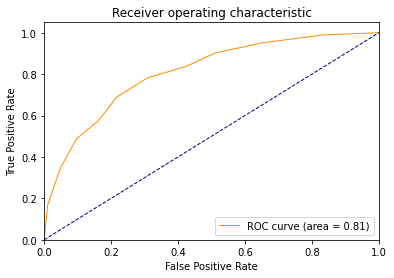

In [16]:
import matplotlib.pyplot as plt

tpr=uc_rdt.metrics_.filter("NAME='ROC_TPR'").select('Y').collect()
fpr=uc_rdt.metrics_.filter("NAME='ROC_FPR'").select('Y').collect()

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % dtr_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Prediction

Obtain the features in the prediction:

In [5]:
features = diabetes_train.columns
features.remove('CLASS')
features.remove('ID')
print(features)

['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'PEDIGREE', 'AGE']


Invoke the prediction with diabetest_test:

In [6]:
pred_res = uc_rdt.predict(diabetes_test, key='ID', features=features)
pred_res.head(10).collect()

,ID,SCORE,CONFIDENCE,REASON_CODE
0,1,1,0.6,"[{""attr"":""AGE"",""pct"":26.0,""val"":0.121846104415..."
1,2,0,0.8,"[{""attr"":""SKINTHICKNESS"",""pct"":28.0,""val"":0.09..."
2,3,0,0.6,"[{""attr"":""AGE"",""pct"":26.0,""val"":0.163377021744..."
3,4,0,1.0,"[{""attr"":""BMI"",""pct"":47.0,""val"":0.185645853162..."
4,5,0,1.0,"[{""attr"":""GLUCOSE"",""pct"":32.0,""val"":0.14688885..."
5,6,1,0.8,"[{""attr"":""GLUCOSE"",""pct"":37.0,""val"":0.24129720..."
6,7,0,0.6,"[{""attr"":""BMI"",""pct"":44.0,""val"":-0.20677675086..."
7,8,0,1.0,"[{""attr"":""PEDIGREE"",""pct"":34.0,""val"":0.1486539..."
8,9,0,0.8,"[{""attr"":""PEDIGREE"",""pct"":38.0,""val"":0.1146918..."
9,10,0,1.0,"[{""attr"":""GLUCOSE"",""pct"":40.0,""val"":0.15685957..."


##### Global Interpretation using Shapley values
Now that we can calculate Shap values for each feature of every observation, we can get a global interpretation using Shapley values by looking at it in a combined form. 
Let’s see how we can do that:

In [7]:
from hana_ml.visualizers.model_debriefing import TreeModelDebriefing

1.Using Shapley values to show the distribution of the impacts each feature has on the model output.
2.The color represents the feature value (red high, blue low).
3.The plot below shows the relationship between feature value and Shapley value.
-- If the dots in the left area are blue and the dots in the right area are red, then it means that the feature value and the Shapley value are typically positive correlation.
-- If the dots in the left area are red and the dots in the right area are blue, then it means that the feature value and the Shapley value are typically negative correlation.
-- If all the dots are concentrated near 0, it means that the Shapley value has nothing to do with this feature.


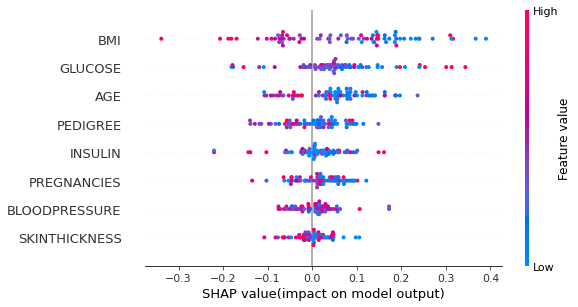

In [8]:
shapley_explainer = TreeModelDebriefing.shapley_explainer(pred_res, diabetes_test, key='ID', label='CLASS')
shapley_explainer.summary_plot()

Expand the REASON_CODE to see the detail of each item:

In [21]:
json2tab_for_reason_code(pred_res).collect()

,ID,SCORE,CONFIDENCE,attr,pct,val
0,1,0.0,0.6,GLUCOSE,36.0,0.139059
1,1,0.0,0.6,PREGNANCIES,23.0,-0.089017
2,1,0.0,0.6,AGE,22.0,-0.086098
3,1,0.0,0.6,BMI,7.0,-0.027160
4,1,0.0,0.6,SKINTHICKNESS,4.0,-0.016254
5,1,0.0,0.6,PEDIGREE,4.0,0.015026
6,1,0.0,0.6,BLOODPRESSURE,3.0,0.012194
7,1,0.0,0.6,INSULIN,1.0,0.003413
8,2,0.0,0.7,AGE,17.0,-0.074615
9,2,0.0,0.7,GLUCOSE,16.0,0.071482


confusion_matrix:

In [19]:
ts = diabetes_test.rename_columns({'ID': 'TID'}) .cast('CLASS', 'NVARCHAR(256)')
jsql = '{}."{}"={}."{}"'.format(pred_res.quoted_name, 'ID', ts.quoted_name, 'TID')
results_df = pred_res.join(ts, jsql, how='inner')
cm_df, classification_report_df = metrics.confusion_matrix(results_df, key='ID', label_true='CLASS', label_pred='SCORE') 

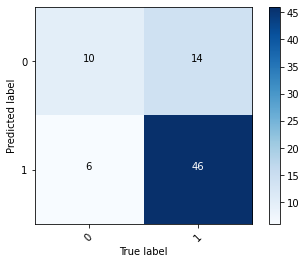

In [20]:
import matplotlib.pyplot as plt
from hana_ml.visualizers.metrics import MetricsVisualizer
f, ax1 = plt.subplots(1,1)
mv1 = MetricsVisualizer(ax1)
ax1 = mv1.plot_confusion_matrix(cm_df, normalize=False)

In [21]:
print("Recall, Precision and F_measures.")
classification_report_df.collect()

Recall, Precision and F_measures.


,CLASS,RECALL,PRECISION,F_MEASURE,SUPPORT
0,0,0.884615,0.766667,0.821429,52
1,1,0.416667,0.625000,0.500000,24


# Score

In [108]:
_,_,_,metrics_res = uc_rdt.score(data=diabetes_test, key='ID', label='CLASS')
metrics_res.collect()

,NAME,X,Y
0,RANDOM_CUMGAINS,0.000000,1.000000
1,RANDOM_CUMGAINS,1.000000,1.000000
2,RANDOM_LIFT,0.000000,1.000000
3,RANDOM_LIFT,1.000000,1.000000
4,RANDOM_CUMLIFT,0.000000,1.000000
5,RANDOM_CUMLIFT,1.000000,1.000000
6,PERF_CUMGAINS,0.000000,0.000000
7,PERF_CUMGAINS,0.039474,0.078947
8,PERF_CUMGAINS,0.078947,0.157895
9,PERF_CUMGAINS,0.118421,0.236842


In [119]:
metrics_res.distinct('NAME').collect()

,NAME
0,RANDOM_CUMGAINS
1,RANDOM_LIFT
2,RANDOM_CUMLIFT
3,PERF_CUMGAINS
4,PERF_LIFT
5,PERF_CUMLIFT
6,ROC_FPR
7,ROC_TPR
8,CUMGAINS
9,LIFT


Draw the cumulative lift curve:

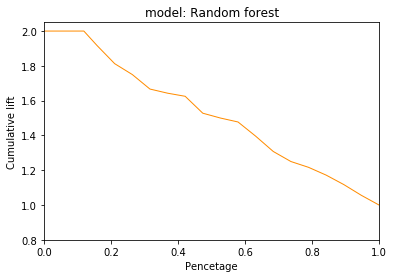

In [117]:
import matplotlib.pyplot as plt
cumlift_x=metrics_res.filter("NAME='CUMLIFT'").select('X').collect()
cumlift_y=metrics_res.filter("NAME='CUMLIFT'").select('Y').collect()
plt.figure()
plt.plot(cumlift_x, cumlift_y, color='darkorange', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.8, 2.05])
plt.xlabel('Pencetage')
plt.ylabel('Cumulative lift')
plt.title('model: Random forest')
plt.show()

Draw the cumulative gains curve:

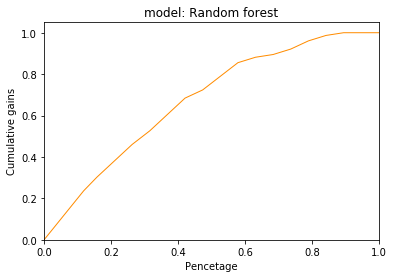

In [124]:
import matplotlib.pyplot as plt
cumgains_x=metrics_res.filter("NAME='CUMGAINS'").select('X').collect()
cumgains_y=metrics_res.filter("NAME='CUMGAINS'").select('Y').collect()
plt.figure()
plt.plot(cumgains_x, cumgains_y, color='darkorange', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Pencetage')
plt.ylabel('Cumulative gains')
plt.title('model: Random forest')
plt.show()